In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from preprocess import Audio_Processor
import classifiers
import feature_reduce
import time
import data_utils as du

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Setup

In [3]:
path_to_db='../ESC-50/'
preprocess = Audio_Processor(path_to_db + 'audio/')
fld = 1

# Load Dataset

In [4]:
dataset = pd.read_csv(path_to_db + 'meta/esc50.csv')

In [5]:
dataset.head()

,filename,fold,target,category,esc10,src_file,take
0,1-100032-A-0.wav,1,0,dog,True,100032,A
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A


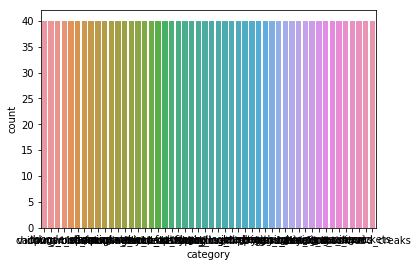

In [6]:
sns.countplot(dataset['category'])

## Preprocessing
Just MFCC were sufficient in previous work.
13 coefficients together with first and second derivatives and remove first energy component.
Should yield vector of 38 features per time frame.

In [22]:
test_file = pd.DataFrame(preprocess.preprocess('1-100032-A-0.wav'))

In [23]:
test_file.head()

,0,1,2,3,4,5,6,7,8,9,...,28,29,30,31,32,33,34,35,36,37
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.837026,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188
1,83.621621,-50.483010,-31.115186,-3.566867,-19.398316,-14.354486,-4.658161,-14.146847,-16.949019,-1.723476,...,4.837026,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188
2,109.848331,-110.083820,-54.568920,-30.153585,-58.985460,-5.598281,-5.862913,17.490401,12.544187,13.053928,...,4.837026,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188
3,77.698670,-123.925469,-64.058169,-27.170063,-57.606930,-9.980594,6.718248,21.293678,15.173490,-1.113725,...,4.837026,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188
4,58.790968,-133.719666,-76.282456,-25.140746,-54.371150,-13.053846,14.737484,17.361937,12.619366,-8.285872,...,4.837026,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188


## Getting Preprocessed Data
We allow for previously preprocessed data to be retrieved for faster training turnaround. If the fold has been preprocessed, it is loaded but if not it is processed and saved.

In [8]:
import pickle
def save_obj(obj, name ):
    with open('../preprocessed_objs/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('../preprocessed_objs/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

def process_fold(fld):
    try:
        df = load_obj("fold_" + str(fld))
    except IOError:
        start_time = time.time()
        df = preprocess.preprocess_fold(fld, dataset, parallel=False)
        print("\tBytes: " + str(df.memory_usage(index=True).sum()))
        print("\tProcessing Time: " + str(time.time() - start_time))
        save_obj(df, "fold_" + str(fld))
    return df

In [9]:
c_data = process_fold(fld)

In [10]:
c_data.head()

,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,...,MFCCp2_4,MFCCp2_5,MFCCp2_6,MFCCp2_7,MFCCp2_8,MFCCp2_9,MFCCp2_10,MFCCp2_11,MFCCp2_12,category
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,dog
1,83.621621,-50.483010,-31.115186,-3.566867,-19.398316,-14.354486,-4.658161,-14.146847,-16.949019,-1.723476,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,dog
2,109.848331,-110.083820,-54.568920,-30.153585,-58.985460,-5.598281,-5.862913,17.490401,12.544187,13.053928,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,dog
3,77.698670,-123.925469,-64.058169,-27.170063,-57.606930,-9.980594,6.718248,21.293678,15.173490,-1.113725,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,dog
4,58.790968,-133.719666,-76.282456,-25.140746,-54.371150,-13.053846,14.737484,17.361937,12.619366,-8.285872,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,dog


In [11]:
n_categories = c_data.category.unique().size

In [12]:
enum_mapping = du.enumerate_strings(c_data)
train_X = c_data.drop(columns=['category'])
train_y = c_data.category

## Overall DNN
Train DNNs for all categories over frames in preprocessed data

In [13]:
dnn = classifiers.gpu_train('dnn', n_categories, train_X, train_y)

Instructions for updating:
Please switch to tf.contrib.estimator.*_head.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f926053ef98>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_eval_distribute': None, '_device_fn': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_log_step_count_steps': 100, '_protocol': None, '_session_config': None, '_save_checkpoints_steps': None, '_keep_checkpoint_max': 5, '_

In [26]:
enum_mapping['category'].inverse_transform(list(dnn.predict(test_file)))

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpyzinusel/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


array(['chirping_birds', 'footsteps', 'dog', 'clapping', 'clapping',
       'crow', 'crow', 'crow', 'crow', 'crow', 'crow', 'crow', 'clapping',
       'clapping', 'clapping', 'clapping', 'clapping', 'can_opening',
       'can_opening'], dtype=object)

In [15]:
from sklearn import metrics
metrics.accuracy_score(train_y, list(dnn.predict(train_X)))

Instructions for updating:
Please switch to predict_classes, or set `outputs` argument.
Instructions for updating:
Estimator is decoupled from Scikit Learn interface by moving into
separate class SKCompat. Arguments x, y and batch_size are only
available in the SKCompat class, Estimator will only accept input_fn.
Example conversion:
  est = Estimator(...) -> est = SKCompat(Estimator(...))
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /tmp/tmpyzinusel/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


0.36360684693108913

## Scoring
Here we get the log likelihood of the categories when matched with its training data

In [ ]:
# a is the audio document A (a matrix of preprocessed audio frames)
# gmm is a category trained gmm
# b_gmm is the background trained gmm
def score(A, gmm, b_gmm, nbytes):
    normalization = 1 / A.shape[0]
    n = gmm.score(A)
    numerator = np.exp(gmm.score(A))
    print(numerator.asarray())
    denominator = cm.exp(b_gmm.score(A))
    print(denominator.asarray())
    T = numerator.divide(denominator)
    B = cm.log(T)
    B.mult(normalization)
    return B.asarray()

In [ ]:
score(test_file, categorical_gmms['dog'], b_gmm, category_processed['dog'].nbytes)

In [ ]:
test_file.shape[1]

# Used for Refresh of Preprocessed Data

In [16]:
process_fold(1)

,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,...,MFCCp2_4,MFCCp2_5,MFCCp2_6,MFCCp2_7,MFCCp2_8,MFCCp2_9,MFCCp2_10,MFCCp2_11,MFCCp2_12,category
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,dog
1,83.621621,-50.483010,-31.115186,-3.566867,-19.398316,-14.354486,-4.658161,-14.146847,-16.949019,-1.723476,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,dog
2,109.848331,-110.083820,-54.568920,-30.153585,-58.985460,-5.598281,-5.862913,17.490401,12.544187,13.053928,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,dog
3,77.698670,-123.925469,-64.058169,-27.170063,-57.606930,-9.980594,6.718248,21.293678,15.173490,-1.113725,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,dog
4,58.790968,-133.719666,-76.282456,-25.140746,-54.371150,-13.053846,14.737484,17.361937,12.619366,-8.285872,...,2.323366,5.238711,0.887285,-0.479714,-2.101468,-2.279721,-0.546664,0.781288,2.636188,dog
5,46.732625,-140.015154,-77.636217,-21.568348,-45.948689,-12.434820,13.665805,13.280903,16.701502,-6.588264,...,1.002889,3.606099,0.589629,-1.947393,-2.317857,-3.166341,0.041054,0.518301,1.423936,dog
6,39.181376,-145.514821,-74.125939,-14.088783,-39.102750,-7.653925,17.287542,13.626261,20.401678,-3.919283,...,-0.788842,0.925724,1.031486,-1.931142,0.047169,-0.927823,0.962924,-0.540372,-0.931430,dog
7,33.212656,-146.715151,-74.675890,-11.374814,-37.126406,-7.770424,19.907019,10.562757,11.747334,-7.930891,...,-0.443805,0.041548,0.145713,-0.804991,0.499212,-0.148896,0.281750,-1.077043,-1.566466,dog
8,32.082811,-138.101436,-71.027465,-18.118563,-29.164880,-6.548451,14.439487,8.505369,1.464637,-14.591160,...,-0.077260,-0.844832,-0.663300,-0.097398,0.630794,0.642361,0.310110,-0.675942,-0.989746,dog
9,36.547908,-129.519841,-65.473908,-18.054138,-15.702643,0.593744,7.194314,6.805723,0.871994,-11.915171,...,0.466876,-1.336518,-0.528341,0.483308,0.646192,1.224463,0.476909,-0.456159,-0.354818,dog


In [17]:
process_fold(2)

	Bytes: 24407216
	Processing Time: 57.429436683654785


,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,...,MFCCp2_4,MFCCp2_5,MFCCp2_6,MFCCp2_7,MFCCp2_8,MFCCp2_9,MFCCp2_10,MFCCp2_11,MFCCp2_12,category
0,91.955220,-8.387198,-0.586808,-12.509792,-11.262680,-17.565894,-10.337254,-8.860041,-8.605315,-9.070141,...,-0.617847,-0.451187,0.113624,-0.430137,-0.998883,0.992282,0.031730,-0.081837,-0.011865,car_horn
1,94.305785,-5.812052,-0.749257,-11.839304,-3.610766,-11.991848,-8.731420,-11.988063,-7.840332,-8.491795,...,-0.617847,-0.451187,0.113624,-0.430137,-0.998883,0.992282,0.031730,-0.081837,-0.011865,car_horn
2,92.824617,-5.830308,-1.213677,-12.448123,-5.186694,-13.331099,-7.786124,-15.919053,-14.180554,-12.859170,...,-0.617847,-0.451187,0.113624,-0.430137,-0.998883,0.992282,0.031730,-0.081837,-0.011865,car_horn
3,96.201440,-3.317330,-2.344180,-3.912286,-6.165752,-15.682039,-9.672855,-12.183134,-17.954351,-11.721714,...,-0.617847,-0.451187,0.113624,-0.430137,-0.998883,0.992282,0.031730,-0.081837,-0.011865,car_horn
4,87.099179,-8.419951,4.427645,2.383146,-12.811991,-10.831010,-6.439645,-8.615088,-11.517763,-5.191099,...,-0.617847,-0.451187,0.113624,-0.430137,-0.998883,0.992282,0.031730,-0.081837,-0.011865,car_horn
5,73.131206,-14.965652,18.386865,1.997784,-19.358578,-6.671836,5.748198,-12.571329,0.987907,-1.510959,...,-0.777879,0.449661,0.162016,-0.632098,-0.725706,0.519744,-0.421523,-0.047950,-0.159050,car_horn
6,65.209579,-5.680334,22.805349,-1.209541,-23.868032,-7.770606,6.199637,-19.624774,-1.020007,-3.200203,...,-0.522344,0.811343,-0.473045,-0.881024,-0.198131,-0.669049,-1.103100,-0.327822,-0.407325,car_horn
7,62.401612,-3.654046,21.326699,-0.477377,-23.213865,-12.124922,-6.052159,-29.922803,-0.390975,-3.145994,...,0.033779,1.194101,-0.879645,-1.040080,0.719725,-1.367566,-1.066966,-0.315938,-0.591145,car_horn
8,69.961948,-3.346804,23.259944,2.032168,-22.425438,-1.867607,-0.499962,-28.482321,4.164743,-3.827302,...,-0.191888,0.616063,-0.304758,-0.215003,1.402660,-0.964957,0.000434,0.420885,-0.313824,car_horn
9,69.490944,-6.852424,13.884905,2.493636,-26.558539,-5.539488,-0.159399,-27.041165,6.771966,-4.713607,...,-0.526448,0.009223,-0.026920,0.796383,1.228717,-0.413147,0.684248,0.673189,-0.329013,car_horn


In [18]:
process_fold(3)

	Bytes: 23834384
	Processing Time: 57.47862434387207


,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,...,MFCCp2_4,MFCCp2_5,MFCCp2_6,MFCCp2_7,MFCCp2_8,MFCCp2_9,MFCCp2_10,MFCCp2_11,MFCCp2_12,category
0,5.002912,4.969333,4.914068,4.838152,4.742989,4.630317,4.502162,4.360777,4.208585,4.048115,...,-1.355655,-0.589515,-0.527817,-0.702433,-0.636914,-0.557782,-0.465581,-0.079061,0.430493,toilet_flush
1,13.022920,12.724257,12.240858,11.593452,10.809448,9.921445,8.965480,7.979122,6.999522,6.061544,...,-1.355655,-0.589515,-0.527817,-0.702433,-0.636914,-0.557782,-0.465581,-0.079061,0.430493,toilet_flush
2,23.193134,22.347546,20.996875,19.224229,17.136689,14.857044,12.514455,10.234890,8.132123,6.300046,...,-1.355655,-0.589515,-0.527817,-0.702433,-0.636914,-0.557782,-0.465581,-0.079061,0.430493,toilet_flush
3,28.247868,27.017136,25.083380,22.603914,19.765946,16.763115,13.775654,10.957320,8.429807,6.283027,...,-1.355655,-0.589515,-0.527817,-0.702433,-0.636914,-0.557782,-0.465581,-0.079061,0.430493,toilet_flush
4,34.362611,29.627125,25.423861,23.293925,21.863594,18.746007,13.494207,8.338235,5.890119,6.330269,...,-1.355655,-0.589515,-0.527817,-0.702433,-0.636914,-0.557782,-0.465581,-0.079061,0.430493,toilet_flush
5,36.189244,29.883846,24.774844,23.074645,22.656831,19.843167,13.772435,7.544614,4.904598,6.123810,...,-1.559493,-0.470826,-0.457292,-0.227208,0.201063,-0.217020,-0.588409,-0.227756,-0.194518,toilet_flush
6,37.743934,30.508589,25.002517,23.839350,24.263869,21.573013,14.538262,6.933582,3.557062,5.105650,...,-1.976399,-0.809836,-0.334942,0.173308,1.233980,0.455190,-0.934616,-0.347389,-0.449261,toilet_flush
7,40.755578,26.289011,18.722800,22.106073,27.793838,26.024115,16.069924,4.948468,-0.232576,2.263728,...,-1.769487,-0.819777,-0.167690,-0.019410,1.603445,1.112352,-0.762038,-0.170353,-0.090253,toilet_flush
8,44.992642,20.938321,12.424495,21.044468,29.081456,23.698150,11.742535,3.992723,0.539151,1.501600,...,-0.657282,-0.601014,-0.021019,-0.588967,0.676840,1.213305,-0.069079,0.351691,0.231522,toilet_flush
9,52.068366,18.904666,22.276019,10.480535,27.645312,23.772460,16.605813,10.987208,-1.167030,-3.961379,...,0.861413,-0.483464,-0.027768,-0.570152,-0.343489,0.830775,0.951102,0.556200,-0.057818,toilet_flush


In [19]:
process_fold(4)

	Bytes: 24590984
	Processing Time: 57.98712730407715


,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,...,MFCCp2_4,MFCCp2_5,MFCCp2_6,MFCCp2_7,MFCCp2_8,MFCCp2_9,MFCCp2_10,MFCCp2_11,MFCCp2_12,category
0,41.688937,-0.784121,9.233285,-5.382688,-8.715239,-14.659339,-1.327415,-11.417957,17.168714,-2.612231,...,0.104462,0.010614,-0.135857,0.219306,0.687372,-0.151290,-0.279909,0.123522,-0.698070,hand_saw
1,32.291193,-3.867387,10.957927,-6.740548,-5.570196,-16.968361,-9.453078,-11.278404,18.857136,-9.719058,...,0.104462,0.010614,-0.135857,0.219306,0.687372,-0.151290,-0.279909,0.123522,-0.698070,hand_saw
2,22.570839,-2.086092,14.259895,-7.800939,-9.795324,-17.932130,-14.454152,-18.758050,17.076609,-8.199059,...,0.104462,0.010614,-0.135857,0.219306,0.687372,-0.151290,-0.279909,0.123522,-0.698070,hand_saw
3,24.124263,3.031151,12.678936,-8.849489,-5.502331,-12.180620,-3.888205,-18.631958,15.612605,-2.430524,...,0.104462,0.010614,-0.135857,0.219306,0.687372,-0.151290,-0.279909,0.123522,-0.698070,hand_saw
4,34.984016,3.814985,6.236857,-12.072855,-0.231755,-10.257718,3.659290,-15.085976,10.695837,-1.147351,...,0.104462,0.010614,-0.135857,0.219306,0.687372,-0.151290,-0.279909,0.123522,-0.698070,hand_saw
5,33.995578,4.816584,11.781560,-11.412660,-3.824205,-11.025078,-1.514752,-20.863222,8.256677,1.152102,...,0.538637,0.199884,-0.938059,-0.316918,1.441102,0.677580,-0.713456,0.376187,0.024351,hand_saw
6,26.655866,-0.626454,9.072685,-13.072765,-1.885551,-10.119194,-3.293233,-21.347038,9.383925,2.328775,...,0.525337,-0.311840,-1.185264,-0.133056,1.312071,1.183303,-0.373001,0.548647,0.698649,hand_saw
7,24.348840,-7.904160,8.335885,-15.546603,-0.360028,-8.610010,-1.947220,-19.683746,3.895086,-0.587604,...,0.590542,-0.370526,-0.384724,0.874115,1.080164,1.082714,0.399200,0.581555,0.667135,hand_saw
8,28.400305,-6.754059,13.232453,-14.211305,1.207461,-10.618494,2.058774,-15.713372,4.339045,-2.702547,...,0.774598,-0.186311,0.143436,0.610373,0.281818,0.489897,0.733709,0.256366,0.330383,hand_saw
9,36.700150,-8.727499,13.773427,-9.258071,5.323213,-17.558884,4.795803,-4.295249,10.631562,1.350331,...,0.762638,0.336904,0.306959,-1.179006,-0.998808,0.027887,0.747709,-0.107076,0.638977,hand_saw


In [20]:
process_fold(5)

	Bytes: 24432176
	Processing Time: 58.05725884437561


,MFCC_1,MFCC_2,MFCC_3,MFCC_4,MFCC_5,MFCC_6,MFCC_7,MFCC_8,MFCC_9,MFCC_10,...,MFCCp2_4,MFCCp2_5,MFCCp2_6,MFCCp2_7,MFCCp2_8,MFCCp2_9,MFCCp2_10,MFCCp2_11,MFCCp2_12,category
0,155.283240,-13.618177,8.876383,-6.257198,-0.145918,15.842328,9.212608,-12.506493,3.139507,6.012983,...,-0.778739,-0.176906,0.670959,-1.136706,1.152326,0.579961,1.084110,-1.710504,-0.474696,pig
1,156.275557,-19.096909,8.090179,-5.873179,10.221067,12.311422,9.331655,-17.197063,3.672138,4.910049,...,-0.778739,-0.176906,0.670959,-1.136706,1.152326,0.579961,1.084110,-1.710504,-0.474696,pig
2,156.202981,-26.551383,10.058584,-1.307025,14.775938,7.967411,16.856608,-23.993008,-6.425508,-3.013177,...,-0.778739,-0.176906,0.670959,-1.136706,1.152326,0.579961,1.084110,-1.710504,-0.474696,pig
3,157.410326,-26.241211,10.547885,-0.005475,10.205764,6.109060,20.295328,-25.845008,-9.541108,-4.345431,...,-0.778739,-0.176906,0.670959,-1.136706,1.152326,0.579961,1.084110,-1.710504,-0.474696,pig
4,159.486831,-22.510336,7.097730,-0.432656,8.305896,8.225068,17.662852,-28.424118,-3.503218,0.069500,...,-0.778739,-0.176906,0.670959,-1.136706,1.152326,0.579961,1.084110,-1.710504,-0.474696,pig
5,156.486456,-22.154643,12.464347,4.344841,9.914556,8.718634,15.351722,-29.361661,-4.257427,0.733840,...,-1.003434,0.172194,0.289592,-1.201058,0.632268,0.861578,1.005279,-1.783470,0.133590,pig
6,163.454552,-27.887494,13.186105,2.088704,12.223108,9.876202,14.784663,-32.245133,-5.448764,1.344780,...,-0.794383,-0.091081,-0.292050,-0.513194,0.300360,0.550921,0.199843,-0.783733,0.762986,pig
7,169.303782,-28.808116,12.129255,-0.872006,14.695483,12.628004,14.967150,-27.418634,-7.713804,2.747226,...,-0.909787,-0.761406,-0.807308,-0.117014,0.588208,0.929874,-0.516863,0.108220,1.199441,pig
8,166.600321,-20.873936,11.509674,-2.356794,16.860531,8.969395,9.256572,-27.215512,-6.832365,7.340725,...,-0.806505,-0.817313,-1.020707,0.225610,0.745033,1.264362,-0.750660,0.624596,0.993143,pig
9,170.741377,-26.522973,12.151779,-5.909328,11.371527,10.803749,5.063379,-32.594092,0.452245,11.521383,...,-0.050442,-0.648185,-1.096929,0.295309,1.016081,0.704801,-1.063779,0.924406,0.205132,pig
